In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table

import sys
sys.path.insert(0, "../")

import velociraptor
from mpl_utils import mpl_style

%matplotlib inline
plt.style.use(mpl_style)

In [6]:
data = Table.read("../data/rv-all.fits")

In [7]:
data.dtype.names

('source_id',
 'ra',
 'dec',
 'l',
 'b',
 'parallax',
 'parallax_error',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'phot_bp_mean_flux',
 'phot_bp_mean_flux_error',
 'phot_bp_n_obs',
 'phot_rp_mean_flux',
 'phot_rp_mean_flux_error',
 'phot_rp_n_obs',
 'phot_bp_rp_excess_factor',
 'bp_rp',
 'bp_g',
 'g_rp',
 'teff_val',
 'teff_percentile_lower',
 'teff_percentile_upper',
 'a_g_val',
 'a_g_percentile_lower',
 'a_g_percentile_upper',
 'radial_velocity',
 'radial_velocity_error',
 'rv_nb_transits',
 'rv_template_teff',
 'rv_template_logg',
 'rv_template_fe_h',
 'astrometric_weight_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'absolute_g_mag',
 'absolute_bp_mag',
 'absolute_rp_mag',
 'rv_single_epoch_variance',
 'p_sb_16',
 'p_sb_50',
 'p_sb_84',
 'rv_excess_variance')

Select only single stars that are in a "nice" part of the H-R diagram.

In [26]:
subset = np.isfinite(data["radial_velocity"]) \
       * (data["p_sb_84"] < 0.001) \
       * ((data["parallax"]/data["parallax_error"]) > 5) \
       * (data["parallax"] > 0) \
       * (data["bp_rp"] < 4)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:929: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


In [27]:
subset.sum()

3595404

(11.305381075621545, -7.716969870538686)

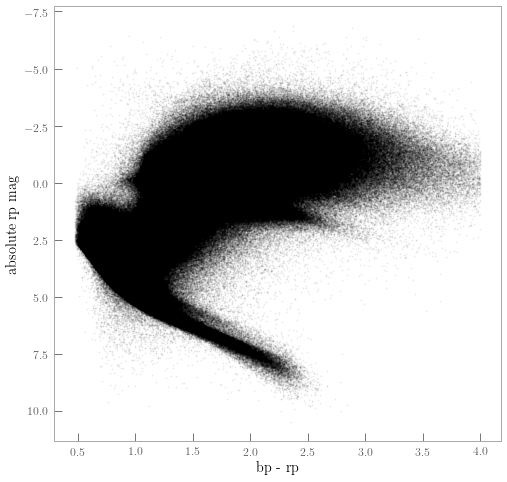

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(data["bp_rp"][subset],
           data["absolute_rp_mag"][subset],
           s=1, alpha=0.05, facecolor="#000000")
ax.set_xlabel(r"\textrm{bp - rp}")
ax.set_ylabel(r"\textrm{absolute rp mag}")
ax.set_ylim(ax.get_ylim()[::-1])

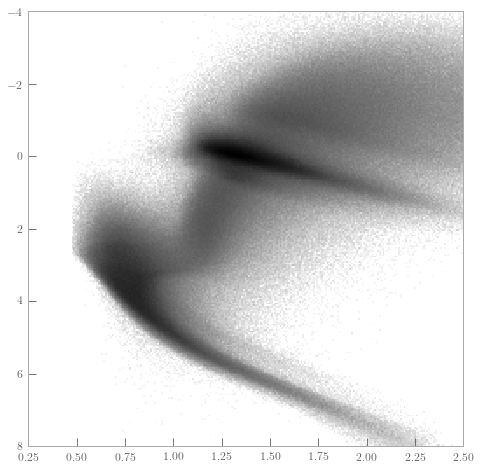

In [77]:
N_bins = 250
H, xedges, yedges = np.histogram2d(
    data["bp_rp"][subset],
    data["absolute_rp_mag"][subset],
    bins=(
        np.linspace(0.25, 2.5, N_bins), 
        np.linspace(-4, 8, N_bins))
)

kwds = dict(
    aspect=np.ptp(xedges)/np.ptp(yedges), 
    extent=(xedges[0], xedges[-1], yedges[-1], yedges[0]),
    cmap="Greys"
)

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(8, 8))
image = ax.imshow(H.T, norm=LogNorm(), **kwds)

Select a small part of colour space on the main-sequence

In [ ]:
x = data["bp_rp"]
y = data["absolute_rp_mag"]

xleft, xright = (, 0.9)

m, b = (-3, 0.0)
ms_subset = subset \
          * (x >= xleft) \
          * (x < xright) \
          * ((y + m * x + b) > 1.5) \
          * (data["absolute_rp_flux"] > 5e7)
#          * ((y + m * x + b) < 6.0)

fig, ax = plt.subplots(figsize=(8, 8))
image = ax.imshow(H.T, norm=LogNorm(), **kwds)
ax.scatter(data["bp_rp"][ms_subset],
           data["absolute_rp_mag"][ms_subset],
           c="b", alpha=0.05, s=1, zorder=100)

Now plot the radial velocity variance across that region

(7, 3)

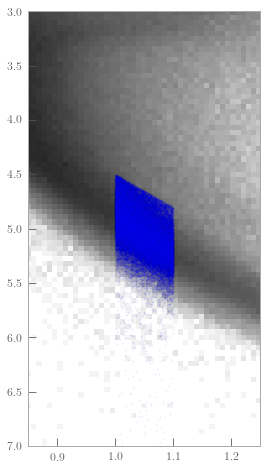

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
image = ax.imshow(H.T, norm=LogNorm(), **kwds)
ax.scatter(data["bp_rp"][ms_subset],
           data["absolute_rp_mag"][ms_subset],
           c="b", alpha=0.05, s=1, zorder=100)
ax.set_xlim(xleft - 0.15, xright + 0.15)
ax.set_ylim(7, 3)

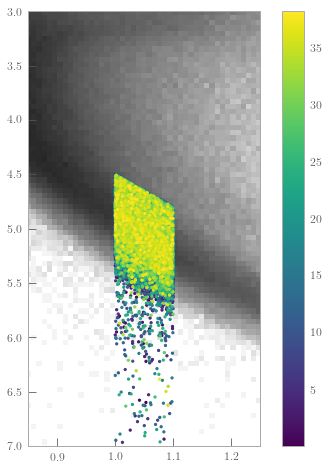

In [107]:
fig, ax = plt.subplots(figsize=(8, 8))
image = ax.imshow(H.T, norm=LogNorm(), **kwds)

x = data["bp_rp"][ms_subset]
y = data["absolute_rp_mag"][ms_subset]
c = data["rv_single_epoch_variance"][ms_subset]

idx = np.argsort(c)
scat = ax.scatter(x[idx], y[idx], c=c[idx],
                  s=5, zorder=100, cmap="viridis")
ax.set_xlim(xleft -0, 1.25)
ax.set_ylim(7, 3)
cbar = plt.colorbar(scat)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


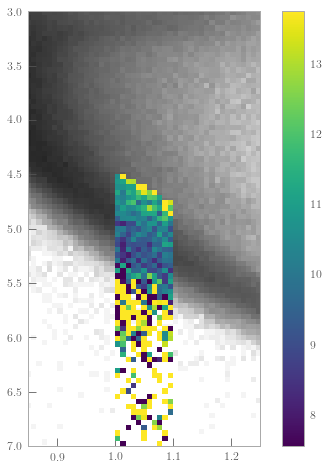

In [110]:
x = data["bp_rp"][ms_subset]
y = data["absolute_rp_mag"][ms_subset]
c = data["rv_single_epoch_variance"][ms_subset]

xb = int(np.ptp(x)/np.ptp(xedges) * xedges.size)
yb = int(np.ptp(y)/np.ptp(yedges) * yedges.size)

H_subset, xe_subset, ye_subset = np.histogram2d(x, y, bins=(xb, yb))
H_subset[:] = 0.0
# Calculate average values in each bin.
for i, xl in enumerate(xe_subset[:-1]):
    xu = xe_subset[i + 1]
    for j, yl in enumerate(ye_subset[:-1]):
        yu = ye_subset[j + 1]
        
        in_bin = (xu > x) * (x >= xl) \
               * (yu > y) * (y >= yl)
        H_subset[i, j] = np.nanmedian(c[in_bin])


subset_kwds = dict(
    aspect=np.ptp(xe_subset)/np.ptp(ye_subset), 
    extent=(xe_subset[0], xe_subset[-1], ye_subset[-1], ye_subset[0]),
    cmap="viridis",
    vmin=np.nanmedian(H_subset) - 0.5 * np.nanstd(H_subset),
    vmax=np.nanmedian(H_subset) + 0.5 * np.nanstd(H_subset)
)
        
fig, ax = plt.subplots(figsize=(8, 8))
image = ax.imshow(H_subset.T, zorder=100, **subset_kwds)
ax.imshow(H.T, norm=LogNorm(), **kwds)
ax.set_xlim(xleft - 0.15, xright + 0.15)
ax.set_ylim(7, 3)
cbar = plt.colorbar(image)

In [94]:
np.nanmedian(H_subset), np.nanstd(H_subset)

(10.660156308061099, 6.212637747920049)

In [68]:
%debug

> <ipython-input-67-96594694fd4b>(13)<module>()
     11 
     12         in_bin = (xu > x) * (x >= xl)                * (yu > y) * (y >= yl)
---> 13         assert 0
     14 
     15 fig, ax = plt.subplots(figsize=(8, 8))

ipdb> H_subset.shape
(30, 15)
ipdb> q
